In [1]:
from sympy import var, Matrix, Rational, eye, init_printing,simplify, solve, sqrt, evalf
import sympy
init_printing()

#Optimal splittings for the classical 44 method

In [2]:
from nodepy import rk

In [3]:
rk4 = rk.loadRKM('RK44')
s = len(rk4)
print rk4

Classical RK4
The original four-stage, fourth-order method of Kutta
 0   |
 1/2 | 1/2
 1/2 |      1/2
 1   |           1
_____|____________________
     | 1/6  1/3  1/3  1/6


Here's what NodePy's implementation gives us, numerically:

In [4]:
rk4.optimal_perturbed_splitting()

(0.6850160627358832,
 array([1.00000000000000, 0.0, 0.0, 0.0, 0.0], dtype=object),
 array([[0, 0, 0, 0, 0],
        [0.671254015683971, 0, 0, 0, 0],
        [0.270090108540258, 0.342508031367942, 0, 0, 0],
        [2.71491162884274e-13, 0, 0.685016062735883, 0, 0],
        [0.306177880587856, 0.176917664597762, 0.150130853210932,
         0.114169343789314, 0]], dtype=object),
 array([[0, 0, 0, 0, 0],
        [0.328745984316029, 0, 0, 0, 0],
        [0.387401860091801, 0, 0, 0, 0],
        [0.0803604341607595, 0.234623503103086, 0, 0, 0],
        [0.252604257814136, 0, 0, 0, 0]], dtype=object))

Now let's investigate analytically.

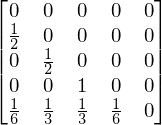

In [5]:
A = Matrix(rk4.A)
b = Matrix(rk4.b)
K = (A.col_join(b.T)).row_join(Matrix([[0],[0],[0],[0],[0]]))
K

In [6]:
r=var('r')
one = Rational(1)
I = eye(s+1)
e = Matrix( [[1],[1],[1],[1],[1]] )
G = I+r*K
Ginv = G.inv()
alpha_r = r*Ginv*K
d_r = Ginv*e

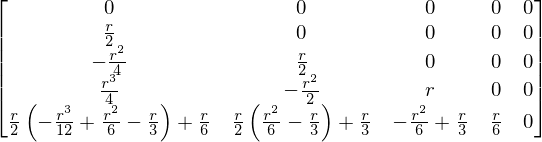

In [7]:
alpha_r

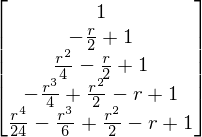

In [8]:
d_r

The optimal perturbed SSP coefficient will turn out to depend on the next-to-last entry of $d_r$ above.

Let's check the sign pattern for a value of $r$ slightly smaller than the optimal:

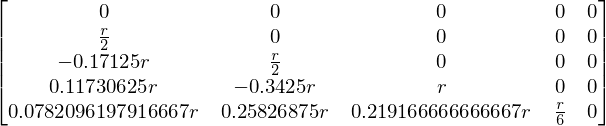

In [9]:
r_num = 0.685
Gnum = I+r_num*K
Gnuminv = Gnum.inv()
alpha_r_num = r*Gnuminv*K
alpha_r_num

Based on the above, we split $\alpha_r = \alpha_r^+ - \alpha_r^-$:

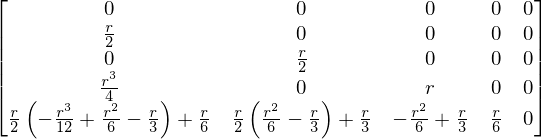

In [10]:
alpha_r_p = alpha_r.copy()
alpha_r_p[2,0] = 0
alpha_r_p[3,1] = 0
alpha_r_p

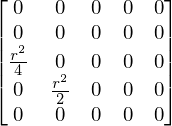

In [11]:
alpha_r_m = alpha_r_p - alpha_r
alpha_r_m

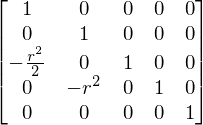

In [12]:
H = I+2*alpha_r_m
Hinv = H.inv()
Hinv

In [13]:
alpha_r_up    = Hinv*alpha_r_p
alpha_r_down  = Hinv*alpha_r_m
gamma_r = (I - 2*alpha_r_down)*d_r

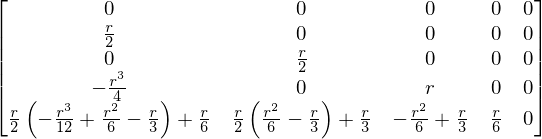

In [14]:
alpha_r_up

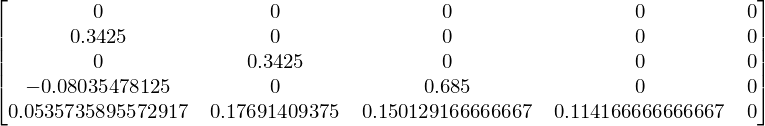

In [15]:
alpha_r_up.subs(r,0.685)

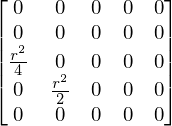

In [16]:
alpha_r_down

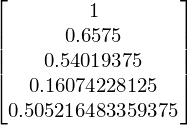

In [17]:
gamma_r[3]=simplify(gamma_r[3])
gamma_r.subs(r,0.685)

### Shu-Osher-like arrays

In [18]:
M = I - alpha_r_up - alpha_r_down
Minv = M.inv()
ee=Minv*gamma_r
for i in range(len(ee)):
    ee[i] = simplify(ee[i])
ee # Should be e

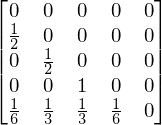

In [19]:
K_new = Minv*(alpha_r_up-alpha_r_down)/r
K_new = K_new.applyfunc(simplify)
K_new # Should be K

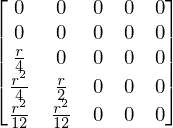

In [23]:
K_tilde = Minv*alpha_r_down/r
K_tilde

## Move the first column values

Now perform the "move" step:

In [20]:
alpha_r_up[3,0] += gamma_r[3]/2
alpha_r_down[3,0] += gamma_r[3]/2
gamma_r[3] = 0

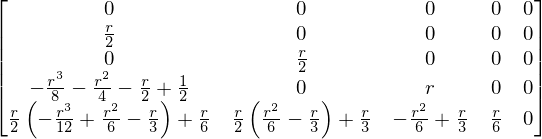

In [21]:
alpha_r_up

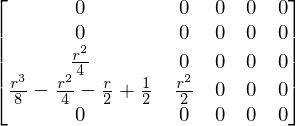

In [22]:
alpha_r_down

In [23]:
X = alpha_r_up[3,0]
-8*X

The optimal coefficient is the real root of this cubic.

In [24]:
S=solve(X,r)
[sympy.N(s) for s in S]

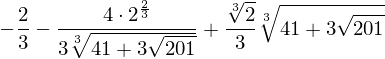

In [25]:
r_opt = simplify(sympy.expand(S[-1]))
r_opt

In [26]:
sympy.N(S[-1])

##Optimal coefficients

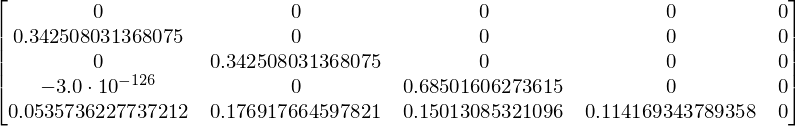

In [27]:
sympy.N(alpha_r_up.subs(r,r_opt))

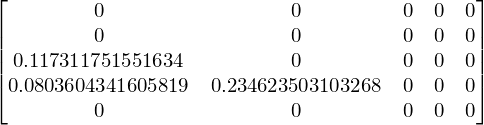

In [28]:
sympy.N(alpha_r_down.subs(r,r_opt))

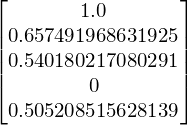

In [29]:
sympy.N(gamma_r.subs(r,r_opt))

# Alternative splitting

We can obtain other optimal splittings by perturbing the $(5,2)$ entry of $\alpha_r^+$ and $\alpha_r^-$.

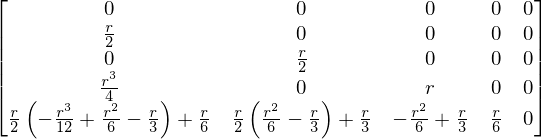

In [35]:
alpha_r_p = alpha_r.copy()
alpha_r_p[2,0] = 0
alpha_r_p[3,1] = 0
alpha_r_p

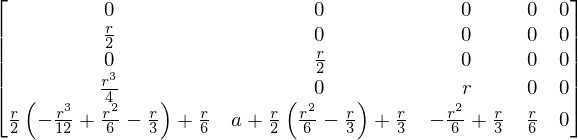

In [36]:
a = var('a')
alpha_r_p[4,1] += a#one/5
alpha_r_p

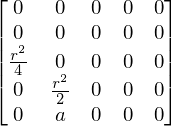

In [37]:
alpha_r_m = alpha_r_p - alpha_r
alpha_r_m

In [38]:
H = I+2*alpha_r_m
Hinv = H.inv()
alpha_r_up    = Hinv*alpha_r_p
alpha_r_down  = Hinv*alpha_r_m
gamma_r = (I - 2*alpha_r_down)*d_r

Move:

In [39]:
alpha_r_up[3,0] += gamma_r[3]/2
gamma_r[3] -= gamma_r[3]/2

In [40]:
alpha_r_up[:,0] += gamma_r/2
alpha_r_down[:,0] += gamma_r/2
for i in range(len(gamma_r)):
    gamma_r[i] = 0

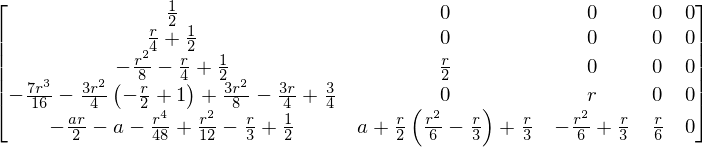

In [41]:
alpha_r_up[4,0] = simplify(alpha_r_up[4,0])
alpha_r_up

In [42]:
Y = alpha_r_up[4,0].subs(r,r_opt)

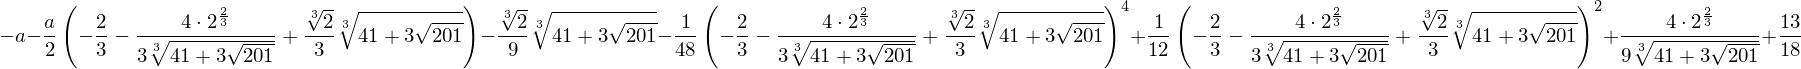

In [43]:
Y

In [44]:
T=solve(Y,a)

In [45]:
aval = sympy.N(T[0])
aval

So the method retains its SSP coefficient as long as $0\le a \le 0.228...$.

Let's double-check:

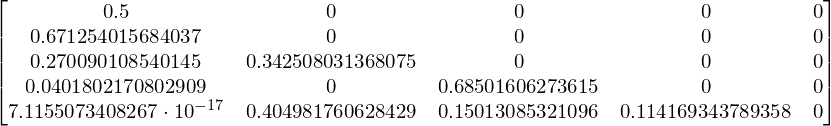

In [46]:
sympy.N(alpha_r_up.subs(r,r_opt).subs(a,aval))

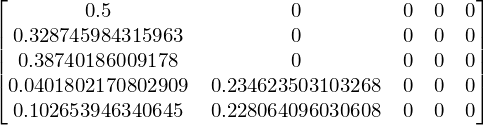

In [47]:
sympy.N(alpha_r_down.subs(r,r_opt).subs(a,aval))

In [48]:
sympy.N(gamma_r.subs(r,r_opt).subs(a,aval))

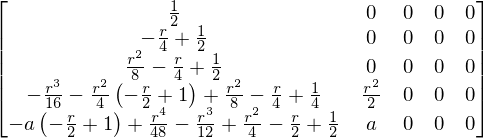

In [49]:
alpha_r_down